# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in **(0,0)**, and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [212]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [213]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [214]:
def compute_distance(x, y):
    # TODO: Compute the Euclidean distance from the origin
    distance = np.sqrt( x**2 + y**2 )
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)
# p: polinomial coefficients, highest degree first

def predict(distance, poly_coeffs):
    # TODO:  Predict the SNR from a given model
    distance_powers = np.ones(shape = (1, len(distance)))
    for k in range(len(poly_coeffs) - 1):
        distance_powers = np.vstack((distance_powers, distance**(k+1)))
    predicted_SNR = np.dot(poly_coeffs[::-1], distance_powers) 
    return predicted_SNR

def evaluate(distance, SNR, poly_coeffs):
    # TODO: Compute the error of the polynomial fit on the chosen data
    predicted_SNR = predict(distance, poly_coeffs)
    mse = np.mean((predicted_SNR - SNR)**2)
    return mse



def separate_test(distance, SNR, test_points):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly
    tot_size = len(SNR)
    idxs = np.arange(tot_size)
    if (test_points <= tot_size):
        test_idxs = np.random.choice(a = idxs, size = test_points)
        train_idxs = np.setdiff1d(idxs, test_idxs)
        x_train = distance[train_idxs,]
        x_test = distance[test_idxs]
        y_train = SNR[train_idxs]
        y_test = SNR[test_idxs]
    else:
        raise ValueError("test_points must be <= dataset size.")
    return x_train, y_train, x_test, y_test

Total points: 200


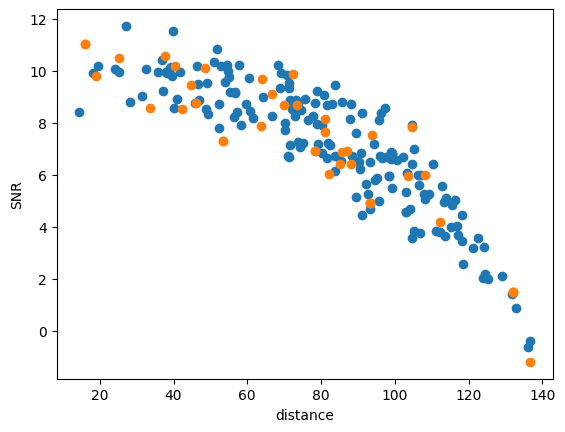

In [215]:
# TODO: separate the training and test sets and create a scatter plot of the SNR as a function of the distance

print(f"Total points: {len(SNR)}")
distance = compute_distance(x, y)

x_train, y_train, x_test, y_test = separate_test(distance, SNR, 40)

plt.scatter(x_train, y_train, label = "train")
plt.scatter(x_test, y_test, label = "test")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.show()

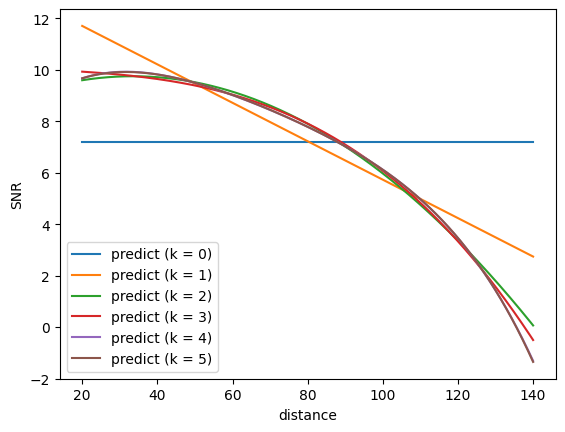

In [216]:
# MY ADDITION: just to verify functions work
for k in range(6):
    x_sample = np.linspace(20, 140, num = 1000)
    p = fit(x_train, y_train, k)
    y_sample_predict = predict(x_sample, p)
    plt.plot(x_sample, y_sample_predict, label = f"predict (k = {k})")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.legend()
plt.show()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [217]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR
    shuffled_idxs = np.arange(len(y_train))
    np.random.shuffle(shuffled_idxs)
    validation_folds_idxs = np.array_split(shuffled_idxs, k)
    train_folds_idxs = [np.setdiff1d(shuffled_idxs, v_idxs) for v_idxs in validation_folds_idxs]
    results = [] # average validation score (one for each subclass)
    for degree in range(max_degree + 1):
        fold_scores = []
        for i in range(k):
            xt_fold, yt_fold = x_train[train_folds_idxs[i]], y_train[train_folds_idxs[i]]
            xv_fold, yv_fold = x_train[validation_folds_idxs[i]], y_train[validation_folds_idxs[i]]
            # find best h among polys of fixed degree
            p = fit(xt_fold, yt_fold, degree)
            validation_score = evaluate(xv_fold, yv_fold, p)
            fold_scores.append(validation_score)
        avg_score, std = np.mean(fold_scores), np.std(fold_scores)
        results.append((avg_score, std))
    avg_scores = [score for score, _ in results]
    best_degree = np.argmin(avg_scores)
    best = fit(x_train, y_train, best_degree)
    return best, results

Best model:[-9.14618471e-08  2.25439753e-05 -2.52165859e-03  9.07923287e-02
  8.88912981e+00]
 Degree: 4


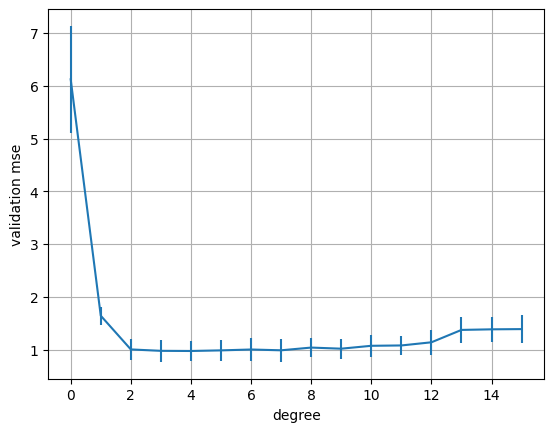

In [218]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds
# TODO: Plot the validation score as a function of the degree

x_train, y_train, x_test, y_test = separate_test(distance, SNR, 40)
max_degree = 15
K = 4
best, results = k_fold_cross_validation(x_train, y_train, K, max_degree)
print("Best model:" + str(best) + "\n Degree: " + str(len(best) - 1))
y = [y for y, _ in results]
y_err = [y_err for _, y_err in results]
plt.errorbar(np.arange(max_degree + 1), y, y_err, label = f"folds: {K}")
plt.xlabel("degree")
plt.ylabel("validation mse")
plt.grid()

MSE of best model, training set: 0.9014095178600595.

MSE of best model, test set: 0.9760339335926332.



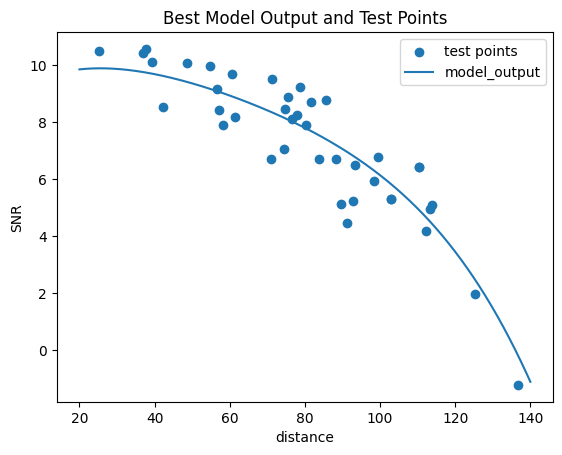

In [219]:
# TODO: get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?


mse_train_best = evaluate(x_train, y_train, best)
mse_test_best = evaluate(x_test, y_test, best)

print("MSE of best model, training set: " + str(mse_train_best) + ".\n")
print("MSE of best model, test set: " + str(mse_test_best) + ".\n")


plt.title("Best Model Output and Test Points")
plt.scatter(x_test, y_test, label = "test points")
x_sample = np.linspace(20, 140, num = 1000)
y_sample_predict = predict(x_sample, best)
plt.plot(x_sample, y_sample_predict, label = f"model_output")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.legend()
plt.show()

*My answer (short version): no, the output changes if we change the number of folds and/or the number of test points, and also if we run the same cross validation at fixed parameters but multiple times.*

*My answer (long version):*

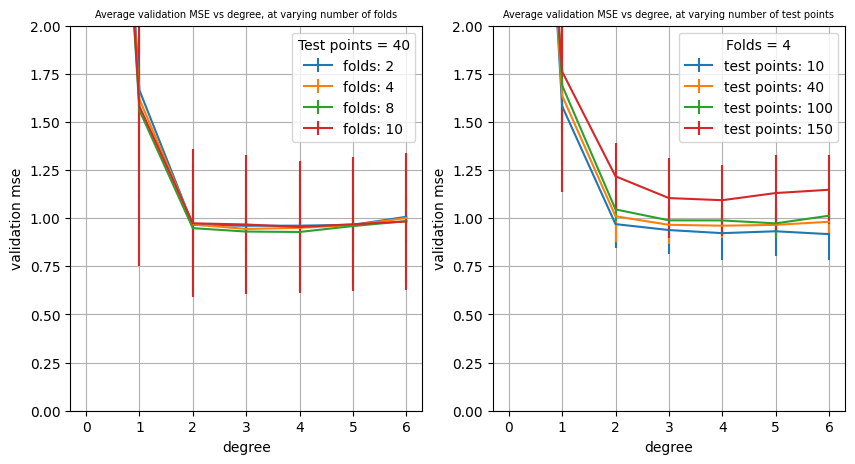

In [220]:
fig, axs = plt.subplots(nrows =  1, ncols = 2, figsize = (10, 5))

# CROSS VALIDATION AT VARYING K
ax = axs[0]
ax.set_title("Average validation MSE vs degree, at varying number of folds",  fontsize= 7)
max_degree = 6
K_list = [2, 4, 8, 10]
for K in K_list:
    _, results = k_fold_cross_validation(x_train, y_train, K, max_degree)
    y = [y for y, _ in results]
    y_err = [y_err for _, y_err in results]
    ax.errorbar(np.arange(max_degree + 1), y, y_err, label = f"folds: {K}")
    ax.set_xlabel("degree")
    ax.set_ylabel("validation mse")
ax.legend(title = "Test points = 40")
ax.set_ylim(0, 2)
ax.grid()

# CROSS VALIDATION AT VARYING test points
ax = axs[1]
ax.set_title("Average validation MSE vs degree, at varying number of test points", fontsize= 7)
K = 4
test_points_list = [10, 40, 100, 150]
for test_points in test_points_list:
    x_train_prova, y_train_prova, _, _ = separate_test(distance, SNR, test_points)
    _, results = k_fold_cross_validation(x_train_prova, y_train_prova, K, max_degree)
    y = [y for y, _ in results]
    y_err = [y_err for _, y_err in results]
    ax.errorbar(np.arange(max_degree + 1), y, y_err, label = f"test points: {test_points}")
    ax.set_xlabel("degree")
    ax.set_ylabel("validation mse")
ax.legend(title = f"Folds = {K}")
ax.set_ylim(0, 2)
ax.grid()


*no, the output is not always the same if varying the number of folds or the number of test points, as you can see from these plots. An increasing trend in the validation score (==loss), coming after a plateau region, indicates that the hypotesis class complexity is becoming too high and the algorithm is overfitting. You can see this kind of trend from the plot, however there is no clear trend of the validation score with respect to the test points number or the folds number, probably because the dataset is too small (?).*

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, **as an alternative to cross-validation** (try $\lambda=0.01$)

In [221]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    best = fit(x_train, y_train, 0)
    best_loss = evaluate(x_train, y_train, best) + lambda_par * np.sum(best ** 2)
    results = []
    for degree in range(max_degree + 1):
        p = fit(x_train, y_train, degree)
        mse = evaluate(x_train, y_train, p)
        loss = mse + lambda_par * np.sum(p**2)
        results.append(loss)
        if loss <= best_loss:
            best = p
            best_loss = loss
    return best, results

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_7838/532117353.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


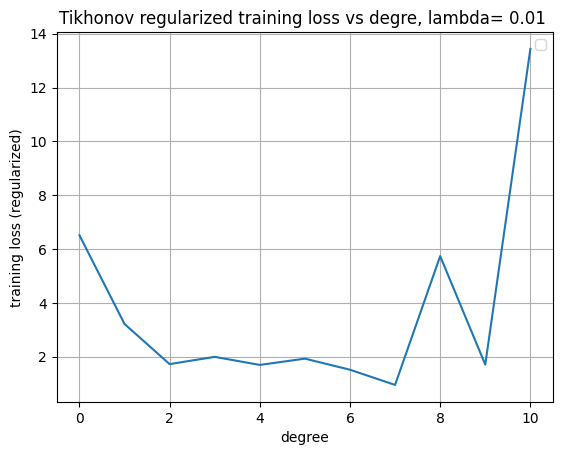

Best model:  [ 2.72668500e-12 -1.48641541e-09  3.29741369e-07 -3.83204478e-05
  2.49531595e-03 -9.04932827e-02  1.65769504e+00 -1.67742748e+00]


In [222]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree
max_degree = 10
lambda_par = 0.01
best_tikhonov, results = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
plt.title(f"Tikhonov regularized training loss vs degre, lambda= {lambda_par} ")
plt.plot(np.arange(max_degree + 1), results)
plt.xlabel("degree")
plt.ylabel("training loss (regularized)")
plt.legend()
plt.grid()
plt.show()

print("Best model: ", best_tikhonov)

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$.


*My note: don't use the formula in the book and slides. This is not standard MDL, it's a made up rule. Just repeat what professor did and ask no questions.*

$$
\text{MSE} \rightarrow \text{MSE} + 2^N* \lambda
$$

In [223]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    best = fit(x_train, y_train, 0)
    best_loss = evaluate(x_train, y_train, best) + lambda_par * (2**0)
    results = []
    for degree in range(max_degree + 1):
        p = fit(x_train, y_train, degree)
        mse = evaluate(x_train, y_train, p)
        loss = mse + lambda_par * 2**(degree)
        results.append(loss)
        if loss <= best_loss:
            best = p
            best_loss = loss
    return best, results

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_7838/4076735470.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


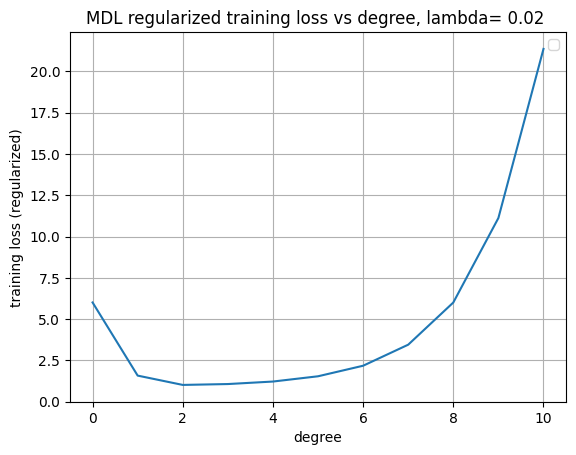

Best model:  [-8.32184870e-04  5.43506406e-02  8.85868312e+00]


In [224]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree
max_degree = 10
lambda_par = 0.02
best_representation, results = evaluate_representation(x_train, y_train, lambda_par, max_degree)
plt.title(f"MDL regularized training loss vs degree, lambda= {lambda_par} ")
plt.plot(np.arange(max_degree + 1), results)
plt.xlabel("degree")
plt.ylabel("training loss (regularized)")
plt.legend()
plt.grid()
plt.show()

print("Best model: ", best_representation)

### TEST

Check the performance of the three solutions on the test set: which one does best?


---- Learning rule ------- Test Loss (MSE)
ERM 0.9760339335926332
Tikhonov 0.9421697469066155
MDL 1.0777022856900298


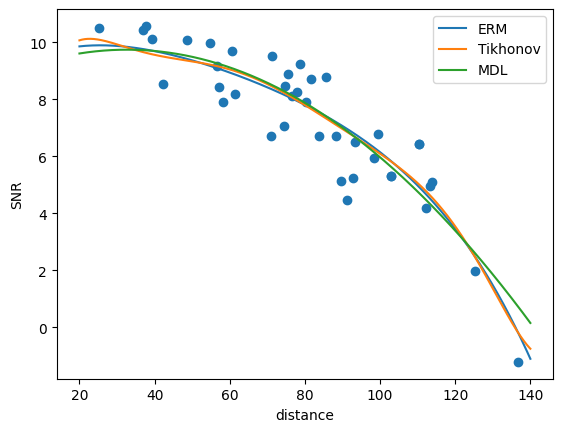

In [225]:
# TODO: plot the results

print("---- Learning rule -------", "Test Loss (MSE)")
print("ERM", evaluate(x_test, y_test, best))
print("Tikhonov", evaluate(x_test, y_test, best_tikhonov))
print("MDL", evaluate(x_test, y_test, best_representation))


x_sample = np.linspace(20, 140, num = 1000)
y_sample_erm = predict(x_sample, best)
y_sample_tik = predict(x_sample, best_tikhonov)
y_sample_mdl = predict(x_sample, best_representation)


plt.plot(x_sample, y_sample_erm, label = "ERM")
plt.plot(x_sample, y_sample_tik, label = "Tikhonov")
plt.plot(x_sample, y_sample_mdl, label = "MDL")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.scatter(x_test, y_test)
plt.legend()
plt.show()